In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
print("pytorch ver . ",torch.__version__)
print("Is CUDA available?",torch.cuda.is_available())
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.utils.data as Data
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import xarray as xr
import os
os.environ['R_HOME'] = '/home/luhung3080/miniconda3/envs/chou/lib/R'
from rpy2.robjects import r, numpy2ri
numpy2ri.activate()
from rpy2.robjects.packages import importr
sinkr = importr('sinkr')
import Nio
print ("pynio ver . ",Nio.__version__)

/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pytorch ver .  1.11.0+cu113
Is CUDA available? True
pynio ver .  1.5.5


# Data

In [2]:
data=pd.read_csv('/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/data_final.csv')
data

,SITE_ID,date,FCST_TIME,TAU,pm25_cal,pm25_obs
0,EPA001,2020-02-24 08:00:00,2020-02-24 09:00:00,1,4.9510,10.0
1,EPA001,2020-02-24 08:00:00,2020-02-24 10:00:00,2,4.4674,13.0
2,EPA001,2020-02-24 08:00:00,2020-02-24 11:00:00,3,4.6159,11.0
3,EPA001,2020-02-24 08:00:00,2020-02-24 12:00:00,4,3.9937,11.0
4,EPA001,2020-02-24 08:00:00,2020-02-24 13:00:00,5,3.9602,9.0
...,...,...,...,...,...,...
3092755,EPA080,2021-10-30 08:00:00,2021-11-02 04:00:00,68,3.6190,4.0
3092756,EPA080,2021-10-30 08:00:00,2021-11-02 05:00:00,69,3.7908,7.0
3092757,EPA080,2021-10-30 08:00:00,2021-11-02 06:00:00,70,4.0454,7.0
3092758,EPA080,2021-10-30 08:00:00,2021-11-02 07:00:00,71,3.9015,4.0


# Pytorch lightning

## Data

In [3]:
x1=np.zeros([604,1704])
x2=np.zeros([604,5112])

#x1 (0th~1703th column as x)
for i in range (0,604):
    for j in range (0,71):
        a=np.array(data['pm25_obs'][5112*i+72*j:5112*i+72*j+24])
        for k in range (0,24):
            x1[i][j*24+k]=a[k]

#x2 (1704th~8519th column as x)
for i in range (1,604):
    b=np.array(data['pm25_cal'][5112*i:5112*i+5112])
    for j in range(0,5112):
        x2[i-1][j]=b[j]
        
print(np.shape(x1))
print(np.shape(x2))

(604, 1704)
(604, 5112)


In [4]:
x1Restruct_Fun=x1
x2Restruct_Fun=x2
print(np.shape(x1Restruct_Fun))
print(np.shape(x2Restruct_Fun))

(604, 1704)
(604, 5112)


In [5]:
YRestruct_Fun=np.zeros([601,5112])
for j in range (0,71):
    for i in range(0,601):
        YRestruct_Fun[i][72*j:72*j+24]=x1Restruct_Fun[1+i][24*j:24*j+24]
        YRestruct_Fun[i][72*j+24:72*j+48]=x1Restruct_Fun[1+i+1][24*j:24*j+24]
        YRestruct_Fun[i][72*j+48:72*j+72]=x1Restruct_Fun[1+i+2][24*j:24*j+24]
print(np.shape(YRestruct_Fun))

(601, 5112)


In [9]:
XRestruct_Fun=np.zeros([601,6816])
for i in range (0,601):
    for j in range (0,1704):
        XRestruct_Fun[i][j]=x1Restruct_Fun[i][j]
    for j in range (1704,6816):
        XRestruct_Fun[i][j]=x2Restruct_Fun[i][j-1704]
print(np.shape(XRestruct_Fun))

(601, 6816)


In [13]:
Xhat=XRestruct_Fun
Yhat=YRestruct_Fun
Xhat_train = np.zeros([540,6816])
Yhat_train = np.zeros([540,5112])
Xhat_val = np.zeros([61,6816])
Yhat_val = np.zeros([61,5112])
Xhat_test = np.zeros([61,6816])
Yhat_test = np.zeros([61,5112])

for i in range (0,540):
    for j in range (0,1704):
        Xhat_train[i][j] = Xhat[i][j]
    for j in range (0,5112):    
        Xhat_train[i][j+1704] = Xhat[i][j+1704]
        Yhat_train[i][j] = Yhat[i][j]
        
for i in range (540,601):
    for j in range (0,1704):
        Xhat_val[i-540][j] = Xhat[i][j]
    for j in range (0,5112):
        Xhat_val[i-540][j+1704] = Xhat[i][j+1704]
        Yhat_val[i-540][j] = Yhat[i][j]     
        
for i in range (540,601):
    for j in range (0,1704):
        Xhat_test[i-540][j] = Xhat[i][j]
    for j in range (0,5112):
        Xhat_test[i-540][j+1704] = Xhat[i][j+1704]
        Yhat_test[i-540][j] = Yhat[i][j]
        
print('Xhat_train')
print(np.shape(Xhat_train))
print('Yhat_train')
print(np.shape(Yhat_train))
print('Xhat_val')
print(np.shape(Xhat_val))
print('Yhat_val')
print(np.shape(Yhat_val))
print('Xhat_test')
print(np.shape(Xhat_test))
print('Yhat_test')
print(np.shape(Yhat_test))

Xhat_train
(540, 6816)
Yhat_train
(540, 5112)
Xhat_val
(61, 6816)
Yhat_val
(61, 5112)
Xhat_test
(61, 6816)
Yhat_test
(61, 5112)


## Model

In [14]:
x_train = torch.from_numpy(Xhat_train).float()
y_train = torch.from_numpy(Yhat_train).float()
x_val = torch.from_numpy(Xhat_val).float()
y_val = torch.from_numpy(Yhat_val).float()
x_test = torch.from_numpy(Xhat_test).float()
y_test = torch.from_numpy(Yhat_test).float()

In [16]:
class PytorchLightningModel(pl.LightningModule): # 一定要繼承pl.LightningModule
    def __init__(self): # 初始化時可以將基本設定傳入。
        super().__init__()
        self.layer1 = nn.Linear(6816 , 5112)

    def forward(self, x): # 定義模型在forward propagation時如何進行.
        ouput = self.layer1(x)
        return ouput

    def configure_optimizers(self): # 自動訓練時會呼叫此方法來獲取Optimizer.
        return optim.Adam(self.parameters(), lr=1e-4) # 這邊注意要調整的參數是`self.parameters()`

    def prepare_data(self): # 此方法會在初始化後優先執行。 所以可以在此方法中先將會用到的資料都讀取進來.
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    # 以下三個方法則是設定進行訓練及驗證時所要使用的Data Loader格式。
    def train_dataloader(self):
        # return Data.DataLoader(dataset=self.train_set, batch_size= self.batch_size, shuffle=True)
        return Data.DataLoader(dataset=self.train_set , batch_size=540 , shuffle=True)

    def test_dataloader(self):
        # return Data.DataLoader(dataset=self.test_set, batch_size= self.batch_size, shuffle=True)
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        #return Data.DataLoader(dataset=self.val_set, batch_size= self.batch_size, shuffle=True)
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

#----------------------------------------------------------------------------------------------------------------------------------------------

    def training_step(self, batch, batch_idx): # 定義訓練過程的Step要如何進行
        x, y = batch # 從self.train_dataloader()的Data Loader取一個batch出來。
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        logs = {'loss' : loss }
        self.log("train_loss_MAE", loss)
        return {'loss' : loss ,'log' : logs }

    def test_step(self, batch, batch_idx): #定義 Test 階段
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        logs = {'loss' : loss }
        self.log("test_loss_MAE", loss)
        return {'loss' : loss ,'log' : logs}

    # def test_eposh_end(self, outputs):
    #     avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
    #     logs = {'test_loss': avg_loss}      
    #     #return {'avg_test_loss': avg_loss, 'log': logs, 'progress_bar': logs }
    #     return {'avg_test_loss': avg_loss, 'log': logs}

    def validation_step(self, batch, batch_idx): # 定義Validation如何進行，以這邊為例就再加上了計算Acc.
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        logs = {'loss' : loss }
        self.log("val_loss_MAE", loss)
        return {'loss' : loss ,  'log' : logs}
    
    # def validation_epoch_end(self, outputs): # 在Validation的一個Epoch結束後，計算平均的Loss.
    #     avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
    #     logs = {'val_loss': avg_loss}
    #     return {'avg_val_loss': avg_loss, 'log' : logs, 'progress_bar': logs}

In [17]:
logger1 = TensorBoardLogger("jupyterNB_logs", name="mymodel_96hr")
logger2 = CSVLogger("jupyterNB_logs", name="mymodel_96hr_csv")
model = PytorchLightningModel() 
trainer = pl.Trainer(max_epochs=500 , gpus=1 , logger=logger2)
trainer.fit(model)
trainer.test(model)
trainer.test(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: jupyterNB_logs/mymodel_96hr_csv
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type   | Params
----------------------------------
0 | layer1 | Linear | 34.8 M
----------------------------------
34.8 M    Trainable params
0         Non-trainable params
34.8 M    Total params
139.394   Total estimated model params size (MB)


/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1942: PossibleUserWarning: The number

Epoch 0:  50%|████████        | 1/2 [00:00<00:00, 45.23it/s, loss=16.4, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|████████        | 1/2 [00:00<00:00,  1.32it/s, loss=13.6, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|████████        | 1/2 [00:01<00:01,  1.55s/it, loss=11.9, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|████████        | 1/2 [00:02<00:02,  2.27s/it, loss=11.1, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|████████        | 1/2 [00:02<00:02,  2.99s/it, loss=10.7, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|████████        | 1/2 [00:03<00:03,  3.70s/it, loss=10.5, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|████████        | 1/2 [00:04<00:04,  4.39s/it, loss=10.2, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|████████        | 1/2 [00:05<00:05,  5.07s/it, loss=9.98, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|████████        | 1/2 [00:05<00:05,  5.75s/it, loss=9.74, v_num=0]
Validation: 0it [00:00,

Epoch 29:  50%|███████▌       | 1/2 [00:20<00:20, 20.12s/it, loss=6.51, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 30:  50%|███████▌       | 1/2 [00:20<00:20, 20.80s/it, loss=6.44, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 31:  50%|███████▌       | 1/2 [00:21<00:21, 21.49s/it, loss=6.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 32:  50%|███████▌       | 1/2 [00:22<00:22, 22.16s/it, loss=6.31, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 33:  50%|███████▌       | 1/2 [00:22<00:22, 22.85s/it, loss=6.24, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 34:  50%|███████▌       | 1/2 [00:23<00:23, 23.53s/it, loss=6.18, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 35:  50%|███████▌       | 1/2 [00:24<00:24, 24.21s/it, loss=6.13, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 36:  50%|███████▌       | 1/2 [00:24<00:24, 24.89s/it, loss=6.08, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 37:  50%|███████▌       | 1/2 [00:25<00:25, 25.57s/it, loss=6.04, v_num=0]
Validation: 0it [00:00,

Epoch 57:  50%|███████▌       | 1/2 [00:39<00:39, 39.23s/it, loss=5.45, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 58:  50%|███████▌       | 1/2 [00:39<00:39, 39.96s/it, loss=5.43, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 59:  50%|███████▌       | 1/2 [00:40<00:40, 40.64s/it, loss=5.41, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 60:  50%|███████▌       | 1/2 [00:41<00:41, 41.32s/it, loss=5.39, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 61:  50%|███████▌       | 1/2 [00:41<00:41, 42.00s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 62:  50%|███████▌       | 1/2 [00:42<00:42, 42.68s/it, loss=5.35, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 63:  50%|███████▌       | 1/2 [00:43<00:43, 43.37s/it, loss=5.34, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 64:  50%|███████▌       | 1/2 [00:44<00:44, 44.05s/it, loss=5.32, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 65:  50%|████████        | 1/2 [00:44<00:44, 44.74s/it, loss=5.3, v_num=0]
Validation: 0it [00:00,

Epoch 86:  50%|█████████         | 1/2 [00:59<00:59, 59.14s/it, loss=5, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 87:  50%|███████▌       | 1/2 [00:59<00:59, 59.82s/it, loss=4.98, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 88:  50%|███████▌       | 1/2 [01:00<01:00, 60.51s/it, loss=4.97, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 89:  50%|███████▌       | 1/2 [01:01<01:01, 61.19s/it, loss=4.96, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 90:  50%|███████▌       | 1/2 [01:01<01:01, 61.88s/it, loss=4.95, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 91:  50%|███████▌       | 1/2 [01:02<01:02, 62.57s/it, loss=4.93, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 92:  50%|███████▌       | 1/2 [01:03<01:03, 63.25s/it, loss=4.92, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 93:  50%|███████▌       | 1/2 [01:03<01:03, 63.94s/it, loss=4.91, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 94:  50%|████████        | 1/2 [01:04<01:04, 64.63s/it, loss=4.9, v_num=0]
Validation: 0it [00:00,

Epoch 114:  50%|███████       | 1/2 [01:18<01:18, 78.32s/it, loss=4.68, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 115:  50%|███████       | 1/2 [01:19<01:19, 79.01s/it, loss=4.67, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 116:  50%|███████       | 1/2 [01:19<01:19, 79.69s/it, loss=4.66, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 117:  50%|███████       | 1/2 [01:20<01:20, 80.37s/it, loss=4.65, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 118:  50%|███████       | 1/2 [01:21<01:21, 81.05s/it, loss=4.64, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 119:  50%|███████       | 1/2 [01:21<01:21, 81.74s/it, loss=4.63, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 120:  50%|███████       | 1/2 [01:22<01:22, 82.43s/it, loss=4.62, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 121:  50%|███████       | 1/2 [01:23<01:23, 83.12s/it, loss=4.61, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 122:  50%|███████▌       | 1/2 [01:23<01:23, 83.80s/it, loss=4.6, v_num=0]
Validation: 0it [00:00,

Epoch 143:  50%|███████       | 1/2 [01:38<01:38, 98.20s/it, loss=4.41, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 144:  50%|███████       | 1/2 [01:38<01:38, 98.90s/it, loss=4.41, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 145:  50%|███████▌       | 1/2 [01:39<01:39, 99.58s/it, loss=4.4, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 146:  50%|██████▌      | 1/2 [01:40<01:40, 100.27s/it, loss=4.39, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 147:  50%|██████▌      | 1/2 [01:40<01:40, 100.95s/it, loss=4.38, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 148:  50%|██████▌      | 1/2 [01:41<01:41, 101.64s/it, loss=4.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 149:  50%|██████▌      | 1/2 [01:42<01:42, 102.33s/it, loss=4.36, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 150:  50%|██████▌      | 1/2 [01:43<01:43, 103.03s/it, loss=4.36, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 151:  50%|██████▌      | 1/2 [01:43<01:43, 103.72s/it, loss=4.35, v_num=0]
Validation: 0it [00:00,

Epoch 171:  50%|███████       | 1/2 [01:57<01:57, 117.50s/it, loss=4.2, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 172:  50%|██████▌      | 1/2 [01:58<01:58, 118.19s/it, loss=4.19, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 173:  50%|██████▌      | 1/2 [01:58<01:58, 118.88s/it, loss=4.18, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 174:  50%|██████▌      | 1/2 [01:59<01:59, 119.57s/it, loss=4.17, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 175:  50%|██████▌      | 1/2 [02:00<02:00, 120.26s/it, loss=4.17, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 176:  50%|██████▌      | 1/2 [02:00<02:00, 120.94s/it, loss=4.16, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 177:  50%|██████▌      | 1/2 [02:01<02:01, 121.64s/it, loss=4.15, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 178:  50%|██████▌      | 1/2 [02:02<02:02, 122.33s/it, loss=4.15, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 179:  50%|██████▌      | 1/2 [02:03<02:03, 123.01s/it, loss=4.14, v_num=0]
Validation: 0it [00:00,

Epoch 200:  50%|████████        | 1/2 [02:17<02:17, 137.42s/it, loss=4, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 201:  50%|██████▌      | 1/2 [02:18<02:18, 138.11s/it, loss=3.99, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 202:  50%|██████▌      | 1/2 [02:18<02:18, 138.80s/it, loss=3.99, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 203:  50%|██████▌      | 1/2 [02:19<02:19, 139.49s/it, loss=3.98, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 204:  50%|██████▌      | 1/2 [02:20<02:20, 140.18s/it, loss=3.98, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 205:  50%|██████▌      | 1/2 [02:20<02:20, 140.86s/it, loss=3.97, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 206:  50%|██████▌      | 1/2 [02:21<02:21, 141.55s/it, loss=3.96, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 207:  50%|██████▌      | 1/2 [02:22<02:22, 142.23s/it, loss=3.96, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 208:  50%|██████▌      | 1/2 [02:22<02:22, 142.92s/it, loss=3.95, v_num=0]
Validation: 0it [00:00,

Epoch 228:  50%|██████▌      | 1/2 [02:36<02:36, 156.64s/it, loss=3.84, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 229:  50%|██████▌      | 1/2 [02:37<02:37, 157.34s/it, loss=3.83, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 230:  50%|██████▌      | 1/2 [02:38<02:38, 158.02s/it, loss=3.83, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 231:  50%|██████▌      | 1/2 [02:38<02:38, 158.72s/it, loss=3.82, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 232:  50%|██████▌      | 1/2 [02:39<02:39, 159.41s/it, loss=3.82, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 233:  50%|██████▌      | 1/2 [02:40<02:40, 160.10s/it, loss=3.81, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 234:  50%|███████       | 1/2 [02:40<02:40, 160.79s/it, loss=3.8, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 235:  50%|███████       | 1/2 [02:41<02:41, 161.47s/it, loss=3.8, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 236:  50%|██████▌      | 1/2 [02:42<02:42, 162.15s/it, loss=3.79, v_num=0]
Validation: 0it [00:00,

Epoch 257:  50%|██████▌      | 1/2 [02:56<02:56, 176.62s/it, loss=3.69, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 258:  50%|██████▌      | 1/2 [02:57<02:57, 177.30s/it, loss=3.68, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 259:  50%|██████▌      | 1/2 [02:57<02:57, 177.98s/it, loss=3.68, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 260:  50%|██████▌      | 1/2 [02:58<02:58, 178.67s/it, loss=3.67, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 261:  50%|██████▌      | 1/2 [02:59<02:59, 179.35s/it, loss=3.67, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 262:  50%|██████▌      | 1/2 [03:00<03:00, 180.04s/it, loss=3.67, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 263:  50%|██████▌      | 1/2 [03:00<03:00, 180.72s/it, loss=3.66, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 264:  50%|██████▌      | 1/2 [03:01<03:01, 181.40s/it, loss=3.66, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 265:  50%|██████▌      | 1/2 [03:02<03:02, 182.09s/it, loss=3.65, v_num=0]
Validation: 0it [00:00,

Epoch 285:  50%|██████▌      | 1/2 [03:15<03:15, 195.85s/it, loss=3.56, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 286:  50%|██████▌      | 1/2 [03:16<03:16, 196.54s/it, loss=3.56, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 287:  50%|██████▌      | 1/2 [03:17<03:17, 197.23s/it, loss=3.55, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 288:  50%|██████▌      | 1/2 [03:17<03:17, 197.92s/it, loss=3.55, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 289:  50%|██████▌      | 1/2 [03:18<03:18, 198.62s/it, loss=3.55, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 290:  50%|██████▌      | 1/2 [03:19<03:19, 199.31s/it, loss=3.54, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 291:  50%|██████▌      | 1/2 [03:20<03:20, 200.00s/it, loss=3.54, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 292:  50%|██████▌      | 1/2 [03:20<03:20, 200.70s/it, loss=3.53, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 293:  50%|██████▌      | 1/2 [03:21<03:21, 201.39s/it, loss=3.53, v_num=0]
Validation: 0it [00:00,

Epoch 314:  50%|██████▌      | 1/2 [03:36<03:36, 216.19s/it, loss=3.44, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 315:  50%|██████▌      | 1/2 [03:36<03:36, 216.87s/it, loss=3.44, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 316:  50%|██████▌      | 1/2 [03:37<03:37, 217.55s/it, loss=3.44, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 317:  50%|██████▌      | 1/2 [03:38<03:38, 218.24s/it, loss=3.43, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 318:  50%|██████▌      | 1/2 [03:38<03:38, 218.92s/it, loss=3.43, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 319:  50%|██████▌      | 1/2 [03:39<03:39, 219.61s/it, loss=3.43, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 320:  50%|██████▌      | 1/2 [03:40<03:40, 220.29s/it, loss=3.42, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 321:  50%|██████▌      | 1/2 [03:40<03:40, 220.98s/it, loss=3.42, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 322:  50%|██████▌      | 1/2 [03:41<03:41, 221.67s/it, loss=3.42, v_num=0]
Validation: 0it [00:00,

Epoch 342:  50%|██████▌      | 1/2 [03:55<03:55, 235.44s/it, loss=3.35, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 343:  50%|██████▌      | 1/2 [03:56<03:56, 236.13s/it, loss=3.34, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 344:  50%|██████▌      | 1/2 [03:56<03:56, 236.82s/it, loss=3.34, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 345:  50%|██████▌      | 1/2 [03:57<03:57, 237.79s/it, loss=3.34, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 346:  50%|██████▌      | 1/2 [03:58<03:58, 238.47s/it, loss=3.33, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 347:  50%|██████▌      | 1/2 [03:59<03:59, 239.17s/it, loss=3.33, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 348:  50%|██████▌      | 1/2 [03:59<03:59, 239.86s/it, loss=3.33, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 349:  50%|██████▌      | 1/2 [04:00<04:00, 240.55s/it, loss=3.32, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 350:  50%|██████▌      | 1/2 [04:01<04:01, 241.24s/it, loss=3.32, v_num=0]
Validation: 0it [00:00,

Epoch 371:  50%|██████▌      | 1/2 [04:15<04:15, 255.77s/it, loss=3.25, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 372:  50%|██████▌      | 1/2 [04:16<04:16, 256.46s/it, loss=3.25, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 373:  50%|██████▌      | 1/2 [04:17<04:17, 257.15s/it, loss=3.25, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 374:  50%|██████▌      | 1/2 [04:17<04:17, 257.84s/it, loss=3.25, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 375:  50%|██████▌      | 1/2 [04:18<04:18, 258.53s/it, loss=3.24, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 376:  50%|██████▌      | 1/2 [04:19<04:19, 259.22s/it, loss=3.24, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 377:  50%|██████▌      | 1/2 [04:19<04:19, 259.92s/it, loss=3.24, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 378:  50%|██████▌      | 1/2 [04:20<04:20, 260.60s/it, loss=3.23, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 379:  50%|██████▌      | 1/2 [04:21<04:21, 261.30s/it, loss=3.23, v_num=0]
Validation: 0it [00:00,

Epoch 399:  50%|██████▌      | 1/2 [04:35<04:35, 275.31s/it, loss=3.17, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 400:  50%|██████▌      | 1/2 [04:36<04:36, 276.01s/it, loss=3.17, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 401:  50%|██████▌      | 1/2 [04:36<04:36, 276.71s/it, loss=3.16, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 402:  50%|██████▌      | 1/2 [04:37<04:37, 277.40s/it, loss=3.16, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 403:  50%|██████▌      | 1/2 [04:38<04:38, 278.09s/it, loss=3.16, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 404:  50%|██████▌      | 1/2 [04:38<04:38, 278.79s/it, loss=3.16, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 405:  50%|██████▌      | 1/2 [04:39<04:39, 279.48s/it, loss=3.15, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 406:  50%|██████▌      | 1/2 [04:40<04:40, 280.17s/it, loss=3.15, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 407:  50%|██████▌      | 1/2 [04:40<04:40, 280.86s/it, loss=3.15, v_num=0]
Validation: 0it [00:00,

Epoch 428:  50%|██████▌      | 1/2 [04:55<04:55, 295.35s/it, loss=3.09, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 429:  50%|██████▌      | 1/2 [04:56<04:56, 296.04s/it, loss=3.09, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 430:  50%|██████▌      | 1/2 [04:56<04:56, 296.72s/it, loss=3.09, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 431:  50%|██████▌      | 1/2 [04:57<04:57, 297.41s/it, loss=3.09, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 432:  50%|██████▌      | 1/2 [04:58<04:58, 298.09s/it, loss=3.08, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 433:  50%|██████▌      | 1/2 [04:58<04:58, 298.78s/it, loss=3.08, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 434:  50%|██████▌      | 1/2 [04:59<04:59, 299.47s/it, loss=3.08, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 435:  50%|██████▌      | 1/2 [05:00<05:00, 300.22s/it, loss=3.08, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 436:  50%|██████▌      | 1/2 [05:00<05:00, 300.92s/it, loss=3.07, v_num=0]
Validation: 0it [00:00,

Epoch 456:  50%|██████▌      | 1/2 [05:14<05:14, 314.74s/it, loss=3.03, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 457:  50%|██████▌      | 1/2 [05:15<05:15, 315.43s/it, loss=3.02, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 458:  50%|██████▌      | 1/2 [05:16<05:16, 316.12s/it, loss=3.02, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 459:  50%|██████▌      | 1/2 [05:16<05:16, 316.82s/it, loss=3.02, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 460:  50%|██████▌      | 1/2 [05:17<05:17, 317.51s/it, loss=3.02, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 461:  50%|██████▌      | 1/2 [05:18<05:18, 318.20s/it, loss=3.02, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 462:  50%|██████▌      | 1/2 [05:18<05:18, 318.89s/it, loss=3.01, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 463:  50%|██████▌      | 1/2 [05:19<05:19, 319.58s/it, loss=3.01, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 464:  50%|██████▌      | 1/2 [05:20<05:20, 320.26s/it, loss=3.01, v_num=0]
Validation: 0it [00:00,

Epoch 485:  50%|██████▌      | 1/2 [05:34<05:34, 334.80s/it, loss=2.96, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 486:  50%|██████▌      | 1/2 [05:35<05:35, 335.48s/it, loss=2.96, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 487:  50%|██████▌      | 1/2 [05:36<05:36, 336.17s/it, loss=2.96, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 488:  50%|██████▌      | 1/2 [05:36<05:36, 336.85s/it, loss=2.96, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 489:  50%|██████▌      | 1/2 [05:37<05:37, 337.53s/it, loss=2.95, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 490:  50%|██████▌      | 1/2 [05:38<05:38, 338.22s/it, loss=2.95, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 491:  50%|██████▌      | 1/2 [05:38<05:38, 338.92s/it, loss=2.95, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 492:  50%|██████▌      | 1/2 [05:39<05:39, 339.61s/it, loss=2.95, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 493:  50%|██████▌      | 1/2 [05:40<05:40, 340.31s/it, loss=2.94, v_num=0]
Validation: 0it [00:00,

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Testing DataLoader 0: 100%|██████████████████████| 1/1 [00:00<00:00, 158.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          5.599172592163086
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████████████████| 1/1 [00:00<00:00, 191.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          5.599172592163086
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_MAE': 5.599172592163086}]

In [18]:
model_test = PytorchLightningModel.load_from_checkpoint('/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/jupyterNB_logs/mymodel_96hr/version_0/checkpoints/epoch=499-step=500.ckpt')
trainer = pl.Trainer()  
trainer.test(model_test)

FileNotFoundError: [Errno 2] No such file or directory: '/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/jupyterNB_logs/mymodel_96hr/version_0/checkpoints/epoch=499-step=500.ckpt'

In [19]:
df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/jupyterNB_logs/mymodel_96hr_csv/version_0/metrics.csv")
s=np.array(df['val_loss_MAE'].fillna(np.nanmean(df['val_loss_MAE'])))
#print(s)
score=np.min(s)
print(df[df['val_loss_MAE'] == score].index)
print(score)

Int64Index([164], dtype='int64')
5.44692850112915


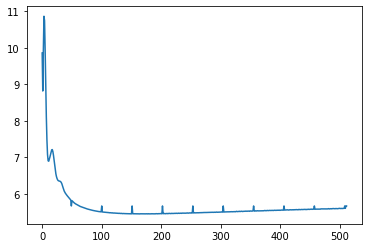

In [20]:
plt.plot(s)

@ terminal
(base) luhung3080@luhung3080:

conda activate chou

cd /home/luhung3080/Desktop/PycharmProjects/NCHUproject/jupyterNB_logs/mymodel

tensorboard --logdir=/home/luhung3080/Desktop/PycharmProjects/NCHUproject/jupyterNB_logs/mymodel/version_3 --host=127.0.0.1
